[View in Colaboratory](https://colab.research.google.com/github/connected-bsamadi/colab-notebooks/blob/master/Package_Recommendation_Engine_Multilabel_Classification.ipynb)

# Setting up

In [0]:
# Google Cloud authentication
from google.colab import auth
auth.authenticate_user()

In [0]:
# Installing packages
!pip install just > /dev/null


In [0]:
from google.cloud import bigquery
import json
import re
import pandas
import sys
import just
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [0]:
# Assigning the project name and creating the BigQuery client
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'ontario-2018'
client = bigquery.Client(project=project_id)

# Data Query
BigQuery is used to get the data from the github_repos dataset.

## Extracting packages

In [6]:
### Get packages from BigQuery
# Original query costs $15
query = r'''
SELECT repo_name, content
FROM `bigquery-public-data:github_repos.contents` contents
INNER JOIN `bigquery-public-data:github_repos.files` files
  ON contents.id = files.id
WHERE files.path = 'package.json'
LIMIT 1000
'''
# Using the saved results
query = r'SELECT * FROM `ontario-2018.github.package`'
# Query the dataset
query_job = client.query(query)
package_df = query_job.to_dataframe()
package_df.shape

(1000, 2)

In [7]:
package_df.head()

,repo_name,content
0,gaccob/diep.io-clone,"{\n ""name"": ""diep.io-clone"",\n\n ""versio..."
1,dglzs/directiveDemo,"{\n ""name"": ""directive-demo"",\n ""version"": ""..."
2,botic/validator,"{\n ""name"": ""validator"",\n ""version"": ""2.1..."
3,Manveer695/susi_viberbot,"{\n ""name"": ""Susi Viber bot"",\n ""version"": ""..."
4,keidrip/keidrip.github.io,"{\n ""devDependencies"": {\n ""textlint"": ""^7..."


In [0]:
# A function to extract name, devDependencies, dependencies and keywords from content
def get_pkg(package_json):
    package_record = {}
    try:
      repo_obj = json.loads(package_json)
      if 'name' in repo_obj:
        package_record['name'] = repo_obj['name']
      if 'devDependencies' in repo_obj:
        dev_dependencies = repo_obj['devDependencies']
        if (len(dev_dependencies) > 0):
          package_record['devDependencies'] = dev_dependencies
      if 'dependencies' in repo_obj:
        dependencies = repo_obj['dependencies']
        if (len(dependencies) > 0):
          package_record['dependencies'] = dependencies
      if 'keywords' in repo_obj:
        keywords = repo_obj['keywords']
        if (len(keywords) > 0):
          package_record['keywords'] = keywords
    finally:
      return package_record

In [9]:
# Extracting devDependencies, dependencies and keywords from package.json
package_df.columns = ['repo_name','package_info']
package_df['package_info']=package_df['package_info'].apply(get_pkg)
package_df.head()

,repo_name,package_info
0,gaccob/diep.io-clone,"{'name': 'diep.io-clone', 'devDependencies': {..."
1,dglzs/directiveDemo,"{'name': 'directive-demo', 'devDependencies': ..."
2,botic/validator,"{'name': 'validator', 'dependencies': {'stick'..."
3,Manveer695/susi_viberbot,"{'name': 'Susi Viber bot', 'dependencies': {'b..."
4,keidrip/keidrip.github.io,"{'devDependencies': {'textlint': '^7.2.1', 'te..."


## Extracting Readme Files

In [10]:
# Get README.md files from dataset
# Original query costs $15
query = r'''
SELECT
  files.repo_name,
  contents.content
FROM
  `bigquery-public-data.github_repos.contents` contents
INNER JOIN
  `bigquery-public-data.github_repos.files` files
ON
  contents.id = files.id
JOIN
  `ontario-2018.github.package100k` packages
ON
  packages.repo_name = files.repo_name
WHERE
  files.path IN ('readme.md',
    'Readme.md',
    'README.md',
    'README.MD')
'''
# Using the saved results
query = r'SELECT * FROM `ontario-2018.github.readme`'
query_job = client.query(query)
readme_df = query_job.to_dataframe()
readme_df.columns = ['repo_name','readme']
readme_df.head()

,repo_name,readme
0,RotatingFans/rotatingfans.github.io,# Jalpc. [![Analytics](https://ga-beacon.appsp...
1,Icenium/node-fibers,fibers(1) -- Fiber support for v8 and Node\n==...
2,tsypa/sms-reg,# sms-reg\n[SMS-REG.com API 2.0](https://sms-r...
3,codenameyau/mean-phonebook,mean-phonebook\n==============\n\nMEAN-Phonebo...
4,request/digest,\n# @request/digest\n\n> See [@request/core][r...


In [11]:
repos = readme_df["repo_name"]
# Number of repositories
len(repos)

948

## Joining the data frames of packages and README files

In [12]:
data=pandas.merge(readme_df,package_df,how='inner')
data.head()

,repo_name,readme,package_info
0,RotatingFans/rotatingfans.github.io,# Jalpc. [![Analytics](https://ga-beacon.appsp...,"{'name': 'Jalpc', 'devDependencies': {'clean-c..."
1,Icenium/node-fibers,fibers(1) -- Fiber support for v8 and Node\n==...,"{'name': 'fibers', 'keywords': ['fiber', 'fibe..."
2,tsypa/sms-reg,# sms-reg\n[SMS-REG.com API 2.0](https://sms-r...,"{'name': 'sms-reg', 'keywords': ['activation',..."
3,codenameyau/mean-phonebook,mean-phonebook\n==============\n\nMEAN-Phonebo...,"{'name': 'meanphonebook', 'devDependencies': {..."
4,request/digest,\n# @request/digest\n\n> See [@request/core][r...,"{'name': '@request/digest', 'dependencies': {'..."


In [13]:
data.shape

(948, 3)

## Listing the packages in all the repositories

In [0]:
def collect_pkg(pckg_info):
  packages_dic = list([])
  if 'devDependencies' in pckg_info:
    packages_dic = packages_dic+list(pckg_info['devDependencies'])
  if 'dependencies' in pckg_info:
    packages_dic = packages_dic+list(pckg_info['dependencies'])
  return packages_dic

In [15]:
data['package_info']=data['package_info'].apply(collect_pkg)
data.head()

,repo_name,readme,package_info
0,RotatingFans/rotatingfans.github.io,# Jalpc. [![Analytics](https://ga-beacon.appsp...,"[clean-css, shelljs, uglify-js, animate.css, b..."
1,Icenium/node-fibers,fibers(1) -- Fiber support for v8 and Node\n==...,[]
2,tsypa/sms-reg,# sms-reg\n[SMS-REG.com API 2.0](https://sms-r...,[]
3,codenameyau/mean-phonebook,mean-phonebook\n==============\n\nMEAN-Phonebo...,"[grunt, grunt-autoprefixer, grunt-bower-instal..."
4,request/digest,\n# @request/digest\n\n> See [@request/core][r...,[node-uuid]


In [16]:
# find all the packages
# list of packages 
pkg_list = [package for pkglist in data['package_info'] for package in pkglist]
# set of packages (no duplicates)
pkg_set = list(set(pkg_list))
count = [pkg_list.count(p) for p in pkg_set]
len(pkg_set)

2880

In [17]:
# find most commonly used packages
pkg_data = {}
pkg_data['count']=count
pkg_data['package']=pkg_set
pkg_df=pandas.DataFrame(data=pkg_data)[['package','count']]
pkg_df=pkg_df.sort_values(by=['count'],ascending=False)
pkg_df.head()

,package,count
2853,mocha,203
2573,grunt,145
502,express,144
734,gulp,133
1025,chai,122


In [18]:
pkg_df.shape

(2880, 2)

In [19]:
# Select the target packages
target_pkg_df=pkg_df.loc[(pkg_df['count'] > 40) & (pkg_df['count'] < 80)]
target_pkg_df

,package,count
1081,babel-loader,79
1456,karma,78
2231,grunt-contrib-clean,76
1731,react-dom,70
1634,gulp-uglify,66
1635,babel-eslint,64
2788,gulp-rename,61
650,bower,61
378,sinon,60
2666,rimraf,60


In [0]:
# Target packages
packages = list(target_pkg_df['package'])
n_packages=len(packages)

In [0]:
def filter_pkg(pkg_info):
  return [pkg for pkg in pkg_info if pkg in packages]

In [22]:
# Remove other packages
data['package_info'] = data['package_info'].apply(filter_pkg)
data.head()
  

,repo_name,readme,package_info
0,RotatingFans/rotatingfans.github.io,# Jalpc. [![Analytics](https://ga-beacon.appsp...,[]
1,Icenium/node-fibers,fibers(1) -- Fiber support for v8 and Node\n==...,[]
2,tsypa/sms-reg,# sms-reg\n[SMS-REG.com API 2.0](https://sms-r...,[]
3,codenameyau/mean-phonebook,mean-phonebook\n==============\n\nMEAN-Phonebo...,"[grunt-contrib-clean, grunt-contrib-concat, gr..."
4,request/digest,\n# @request/digest\n\n> See [@request/core][r...,[]


In [23]:
# Remove repos with empty packages
data = data.drop([i for i in data.index if len(data['package_info'][i])==0])
data.head()

,repo_name,readme,package_info
3,codenameyau/mean-phonebook,mean-phonebook\n==============\n\nMEAN-Phonebo...,"[grunt-contrib-clean, grunt-contrib-concat, gr..."
5,gnandretta/babel-plugin-transform-css-import-t...,# babel-plugin-transform-css-import-to-string\...,[babel-cli]
6,james-logan/compendium,# compendium\n\n\nA book tracking app geared t...,"[grunt-contrib-clean, grunt-contrib-copy, grun..."
7,james-logan/thematica,# compendium\n\n\nA book tracking app geared t...,"[grunt-contrib-clean, grunt-contrib-copy, grun..."
17,davidknoll/mongofuse,"# mongofuse\nA FUSE filesystem, powered by Mon...",[async]


# Training data

In [0]:
# One-hot encoding of packages in repos
n_repos=data.shape[0]
n_pkgs=len(packages)
y = np.zeros((n_repos,n_pkgs))
for n_repo, i in zip(range(len(data.index)),data.index):
  for n_pkg, pkg in zip(range(len(packages)),packages):
    if pkg in data['package_info'][i]:
      y[n_repo,n_pkg] = 1

In [0]:
readme_train=data["readme"]
max_features = 1000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(readme_train))
readme_tokenized_train = tokenizer.texts_to_sequences(readme_train)

In [26]:
dir(tokenizer)
print(tokenizer.word_counts)

OrderedDict([('mean', 384), ('phonebook', 3), ('is', 2548), ('a', 4301), ('minimal', 14), ('crud', 8), ('application', 383), ('built', 98), ('using', 519), ('the', 9468), ('angular', 554), ('fullstack', 6), ('click', 103), ('here', 237), ('https', 3142), ('bitbucket', 2), ('org', 1017), ('accountname', 2), ('blog', 62), ('to', 5951), ('view', 76), ('project', 558), ('that', 1137), ('uses', 138), ('flask', 5), ('and', 3565), ('sqlalchemy', 1), ('for', 2553), ('back', 74), ('end', 207), ('front', 31), ('live', 52), ('demo', 153), ('deployed', 15), ('on', 1330), ('heroku', 135), ('herokuapp', 19), ('com', 2657), ('file', 748), ('structure', 72), ('files', 474), ('in', 2524), ('app', 999), ('scripts', 160), ('express', 164), ('api', 615), ('lib', 66), ('development', 346), ('setup', 116), ('1', 919), ('clone', 203), ('this', 1961), ('repository', 152), ('2', 569), ('run', 947), ('npm', 1499), ('install', 1130), ('bower', 413), ('3', 373), ('serve', 70), ('grunt', 478), ('deploying', 27), (

In [0]:
maxlen = 500
X_t = pad_sequences(readme_tokenized_train, maxlen=maxlen)

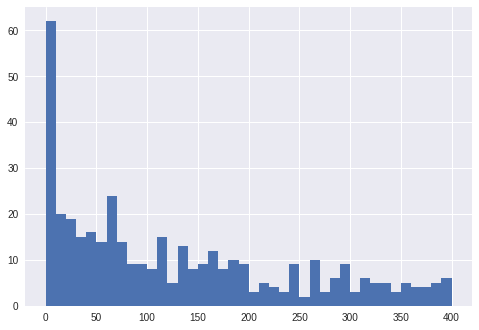

In [28]:
totalNumWords = [len(readme) for readme in readme_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

# Bag of Words Model

## Building the model

In [0]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(maxlen,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512, input_shape=(maxlen,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_packages))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               256512    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 31)                15903     
__________

## Training

In [31]:
batch_size = 32
epochs = 128
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 494 samples, validate on 55 samples
Epoch 1/128
494/494 [==============================] - 1s 1ms/step - loss: 29.8843 - acc: 0.1215 - val_loss: 33.5308 - val_acc: 0.1818
Epoch 2/128
494/494 [==============================] - 0s 478us/step - loss: 28.7153 - acc: 0.1235 - val_loss: 30.6964 - val_acc: 0.1636
Epoch 3/128
494/494 [==============================] - 0s 448us/step - loss: 26.1006 - acc: 0.1377 - val_loss: 28.8670 - val_acc: 0.1636
Epoch 4/128
494/494 [==============================] - 0s 456us/step - loss: 24.0887 - acc: 0.1356 - val_loss: 28.3841 - val_acc: 0.1636
Epoch 5/128
494/494 [==============================] - 0s 449us/step - loss: 22.9934 - acc: 0.1377 - val_loss: 25.8304 - val_acc: 0.1636
Epoch 6/128
494/494 [==============================] - 0s 449us/step - loss: 21.5722 - acc: 0.1377 - val_loss: 21.7488 - val_acc: 0.1636
Epoch 7/128
494/494 [==============================] - 0s 454us/step - loss: 20.5059 - acc: 0.1316 - val_loss: 21.8086 - val_acc: 0.163

## Prediction

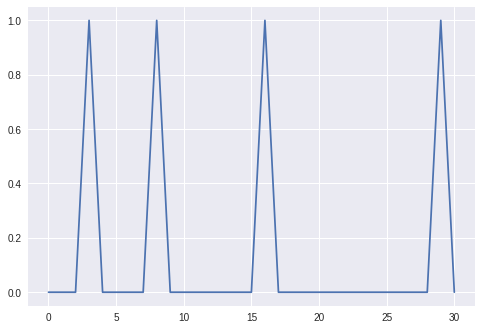

In [32]:
n_t=10
x_tst=np.reshape(X_t[n_t,:],(1,maxlen))
plt.plot(y[n_t,:])

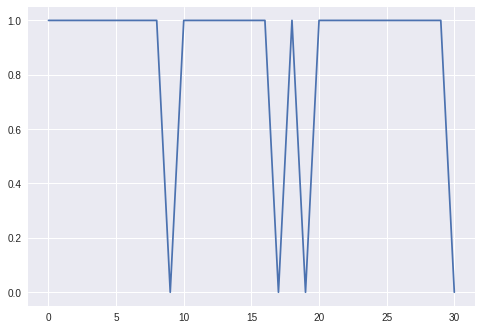

In [33]:
y_p = model.predict(x_tst, verbose=0)[0]
plt.plot(y_p)

# LSTM model
reference: [Tackling  "Toxic Comment Classification Challenge" with Keras](https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras)

## Building the model

In [0]:
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(n_packages, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          128000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 500, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

## Training

In [36]:
batch_size = 32
epochs = 4
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 494 samples, validate on 55 samples
Epoch 1/4
494/494 [==============================] - 11s 22ms/step - loss: 0.6752 - acc: 0.6764 - val_loss: 0.6306 - val_acc: 0.7889
Epoch 2/4
494/494 [==============================] - 10s 20ms/step - loss: 0.5260 - acc: 0.8083 - val_loss: 0.4382 - val_acc: 0.8633
Epoch 3/4
494/494 [==============================] - 10s 20ms/step - loss: 0.3791 - acc: 0.8828 - val_loss: 0.3683 - val_acc: 0.8897
Epoch 4/4
494/494 [==============================] - 10s 20ms/step - loss: 0.3385 - acc: 0.9003 - val_loss: 0.3482 - val_acc: 0.8897


## Prediction

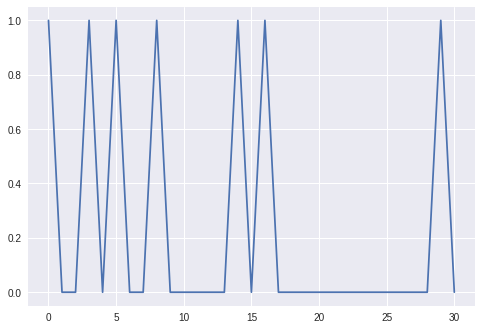

In [37]:
n_t=100
x_tst=np.reshape(X_t[n_t,:],(1,maxlen))
plt.plot(y[n_t,:])

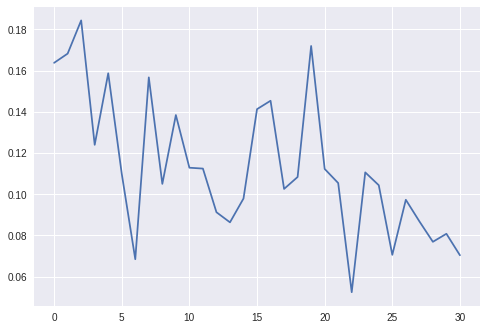

In [38]:
y_p = model.predict(x_tst, verbose=0)[0]
plt.plot(y_p)